# SPOTPY - calibración
***
_Autor:_    __Jesús Casado__ <br> _Revisión:_ __6/12/2019__ <br>

__Introducción__<br>
Se dcalibra el modelo de nieve de la cuenca alta del Deva mediante el algoritmo de optimización SCEUA.

* Los parámetros a calibrar en el modelo se definen en el  archivo _parametros.yml_.

__Cosas a mejorar__ <br>

__Índice__ <br>

***

In [1]:
import os
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import spotpy
from netCDF4 import Dataset
from datetime import date, datetime, timedelta
from pyproj import Proj, Transformer, CRS
from calendar import monthrange

In [2]:
rutaBase = os.getcwd()

In [3]:
%run spotpy_setup.ipynb

In [4]:
os.chdir(os.path.join(rutaBase, '../'))
%run funciones_raster.ipynb
%run funciones_modelo_nieve.ipynb
%run class_MODIS.ipynb
os.chdir(rutaBase)

## 1. Datos
### 1.1 Cartografía

In [5]:
# ruta cartografía
rutaGIS = os.path.join(rutaBase, '../../data/GIS/')

# importar polígonos de las cuencas
cuenca = gpd.read_file(rutaGIS + "mask_465_deva.shp")

# importar mdt de la cuenca
DEM = read_ascii(rutaGIS + 'dem_465_deva.asc', crs=25830)
DEM.variable = 'elevación'
DEM.units = 'm.s.n.m'

### 1.2 Nieve MODIS

In [6]:
# Cargar netCDF con los datos climáticos
rutaMODIS = os.path.join(rutaBase, '../../data/SnowCover/')
nc = Dataset(rutaMODIS + 'MODIS_Maximum_Snow_Extent_Terra+Aqua.nc', 'r', format='NETCDF4')

# extraer datos
data = nc['SC'][::]
units = nc['SC'].units
# fechas
times = np.array([datetime(1, 1, 1).date() + timedelta(time) for time in nc['time'][:].data])
# coordenadas
X = nc['X'][:].data
Y = nc['Y'][:].data
crs = CRS.from_epsg(nc.coordinateSystem.split(':')[1])

# guardar como objeto raster3D
SCobs = raster3D(data, X, Y, times, variable='snow cover', label='SC', units=units,
                   crs=crs)

nc.close()

#### Fechas de MODIS

In [7]:
# definir fechas de inicio y fin de los datos de MODIS
start, end = SCobs.times.min(), SCobs.times.max()
start = datetime(start.year, start.month, 1).date()
end = datetime(end.year, end.month, monthrange(end.year, end.month)[1]).date()

### 1.3 Precipitación y temperatura

In [8]:
# Cargar netCDF con los datos climáticos
rutaClima = os.path.join(rutaBase, '../../data/clima/')
nc = Dataset(rutaClima + 'clima_1265.nc', 'r', format='NETCDF4')

# extraer variables
X = nc['X'][:].data
Y = nc['Y'][:].data
dates = nc['time'][:].data
dates = np.array([date(1979, 1, 1) + timedelta(days=int(d)) for d in dates])
pcp = nc['pcp'][::].data
tmp = nc['tmp'][::].data

nc.close()

In [9]:
# guardar como objetos raster3D
PCP = raster3D(pcp, X, Y, dates, units='mm', variable='Precipitación', label='P',
            crs=CRS.from_epsg(25830))

TMP = raster3D(tmp, X, Y, dates, units='°C', variable='Temperatura', label='T',
            crs=CRS.from_epsg(25830))

In [10]:
# recortar a las fechas de MODIS
PCP.extraer(start, end, axis=0, inplace=True)
TMP.extraer(start, end, axis=0, inplace=True)

In [11]:
# enmascarar celdas sin ningún dato
PCP.enmascararNaN()
TMP.enmascararNaN()

### 1.4 Radiación

In [13]:
rad = np.zeros((12, *DEM.data.shape)) * np.nan
for i in range(1, 7):
    asci = read_ascii(rutaClima + 'rad{0:02d}.asc'.format(i))
    radi = asci.data
    if i == 1:
        # arrays de coorenadas
        ncols, nrows, xll, yll, cs, noDATA = asci.attributes
        Xrad = np.arange(xll, xll + cs *ncols, cs)
        Yrad = np.arange(yll, yll + cs *nrows, cs)[::-1]
        # recortar filas y columnas sin dato
        radi, Xrad, Yrad = corregirRaster(radi, Xrad, Yrad)
    else:
        # recortar filas y columnas sin dato
        radi = corregirRaster(radi)
    # asignar mapa
    rad[i-1,:,:] = radi.copy()
    rad[12-i,:,:] = radi.copy()

In [14]:
# guardar como objeto raster3D
RAD = raster3D(rad, Xrad, Yrad, np.arange(1, 13), variable='radiación', units='-',
               label='Rad', crs=CRS.from_epsg(25830))
RAD.enmascararNaN()

## 2. Calibración 

### 2.1 Lanzar calibración

In [18]:
# importar parámetros a calibrar
with open("parametros.yml", "r") as ymlfile:
    pars = yaml.load(ymlfile, Loader=yaml.FullLoader)
pars

{'Tb': {'min': -2, 'max': 6, 'ini': 0},
 'DDF1': {'min': 0, 'max': 6, 'ini': 3},
 'DDF2': {'min': 0, 'max': 10, 'ini': 5}}

In [ ]:
setup = spotpy_setup(PCP, TMP, SCobs, pars, RAD=RAD, obj_func=rendimiento_clasificacion)

In [ ]:
sampler = spotpy.algorithms.sceua(setup, dbname='SCEUA_DDM', dbformat='csv')

In [ ]:
#Select number of maximum repetitions
rep = 1000

In [ ]:
sampler.sample(rep, ngs=7, kstop=3, peps=0.1, pcento=0.1)

### 2.2 Resultados de la calibración

In [15]:
# importar resultados
sceua = pd.read_csv('SCEUA_DDM.csv', usecols=range(4))

sceua.shape

(392, 4)

No entiendo por qué a pesar de definir 1000 iteraciones, en el archivo de salida de la calibración sólo se guardan 392.

In [16]:
# extraer mejor rendimiento y sus parámetros asociados
best_idx = sceua.like1.idxmin()
best_pars = sceua.loc[best_idx].iloc[1:]
best_pars.index = [idx[3:] for idx in best_pars.index]
best_OF = sceua.like1.min()
print('f1 = {0:.3f}'.format(best_OF))
for par in best_pars.index:
    print('{0} = {1:.3f}'.format(par, best_pars[par]), end='\t')

f1 = 0.108
Tb = 3.586	DDF1 = 0.722	DDF2 = 9.130	

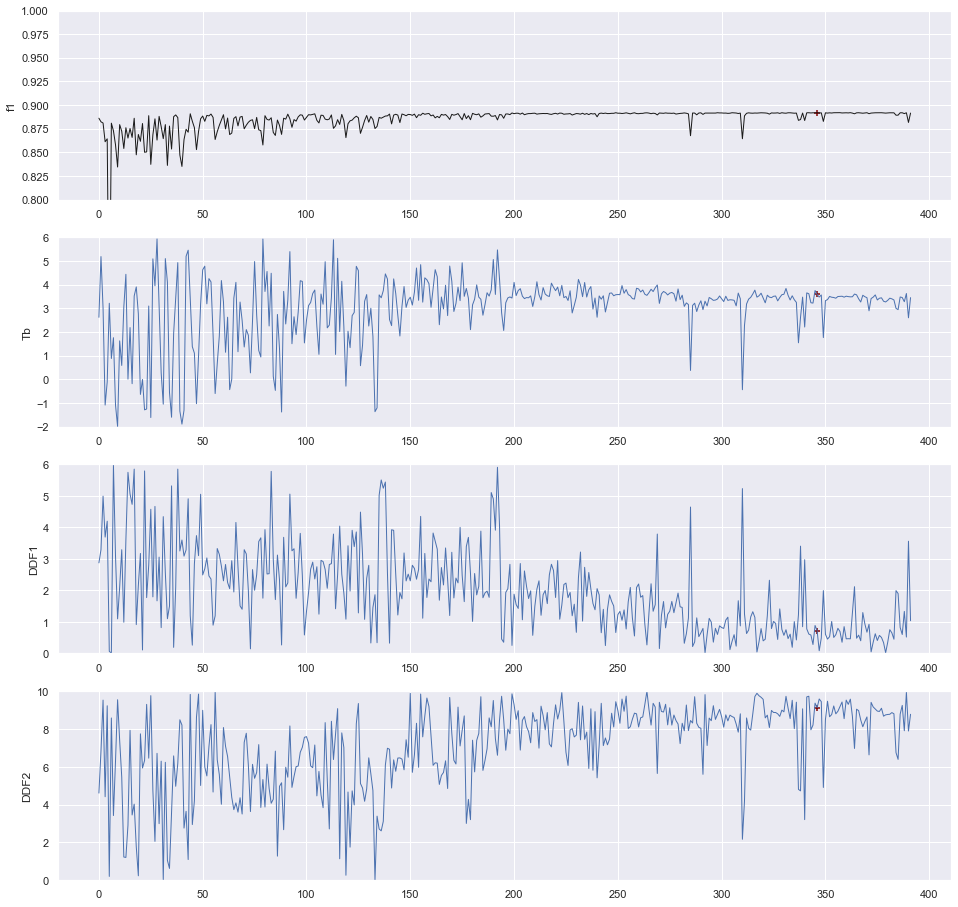

In [19]:
# gráficos de la evolución de la calibración
fig, axes = plt.subplots(nrows=4, figsize=(16, 16))

axes[0].plot(1 - sceua.like1, c='k', lw=1)
axes[0].scatter(best_idx, 1 - sceua.loc[best_idx, 'like1'], marker='+', color='maroon')
axes[0].set(ylabel='f1', ylim=(0.8, 1))
for ax,  par in zip(axes[1:], pars):
    ax.plot(sceua['par' + par], lw=1)
    ax.scatter(best_idx, sceua.loc[best_idx, 'par' + par], marker='+', color='maroon')
    ax.set(ylabel=par, ylim=(pars[par]['min'], pars[par]['max']))

## 3 Simulación

In [29]:
# calcular modelo de nieve
SWE, SM = degreeDayMethod(PCP, TMP, RAD=RAD, Ts=0., Tb=best_pars['Tb'],
                                DDF1=best_pars['DDF1'], DDF2=best_pars['DDF2'],
                                verbose=True)

# reclasificar SWE en un mapa binario
SCsim = snowCover(SWE, threshold=1)

# agregar simulación a paso 8 días
SCsim8 = remuestrearMODIS(SCobs, SCsim, func='max')
SWEsim8 = remuestrearMODIS(SCobs, SWE, func='max')

In [ ]:
# rendimiento en f1_score
f1Serie = rendimiento_clasificacion(SCobs, SCsim8, score='f1')
f1Mean = f1Serie.mean()

In [24]:
rutaOut = os.path.join(rutaBase, '../../output/')

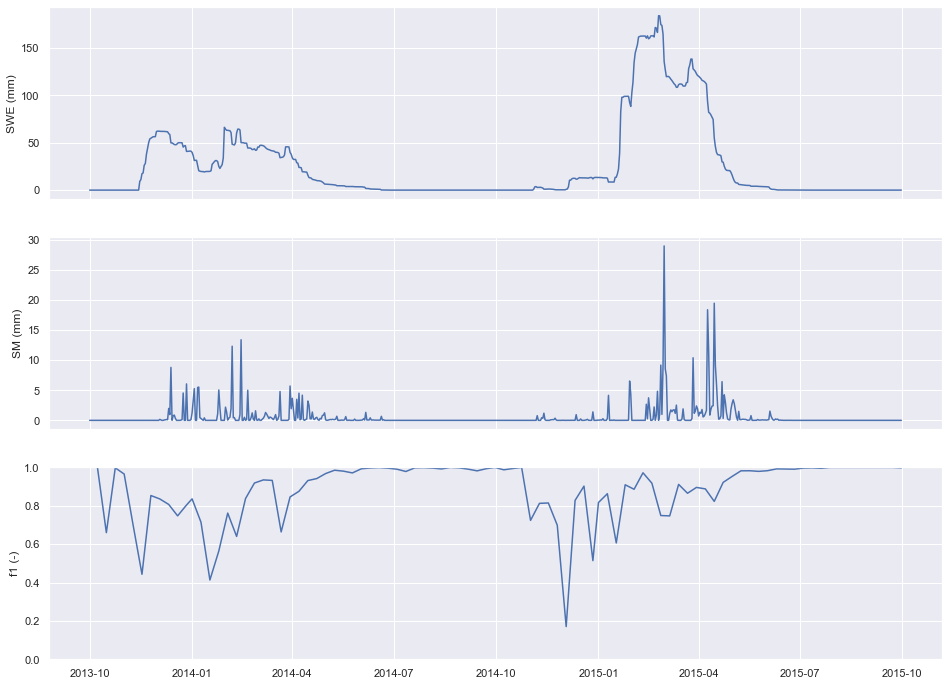

In [45]:
# serie de resultados
serieSWE = pd.Series(np.nanmean(SWE.data, axis=(1,2)), index=SWE.times)
serieSM = pd.Series(np.nanmean(SM.data, axis=(1,2)), index=SM.times)

fig, axes = plt.subplots(nrows=3, figsize=(16, 12), sharex=True, sharey=False)
# series simuladas: snow-water equivalent, snowmelt
for ax, serie, label in zip(axes[:2], [serieSWE, serieSM], ['SWE', 'SM']):
    ax.plot(serie)
    ax.set_ylabel(label + ' (mm)')
# serie de rendimiento
axes[2].plot(f1Serie)
axes[2].set(ylabel='f1 (-)', ylim=(0, 1))
plt.savefig(rutaOut + 'Series_resultados_DDM.png', dpi=600, bbox_inches='tight');

In [31]:
# definir colores
colors = np.array([[255, 255, 255 , 0], [33, 178, 171, 130]])
colors = colors / 255.
cmap_snow = ListedColormap(colors)
boundaries = [0, .5, 1]
norm = BoundaryNorm(boundaries, cmap.N, clip=True)
snow_patch = mpatches.Patch(color=cmap.colors[1], label='snow')

In [27]:
# definir límites del mapa
xmin, ymin, xmax, ymax = cuenca.bounds.values[0]
xmin -= DEM.cellsize * 2
ymin -= DEM.cellsize * 2
xmax += DEM.cellsize * 2
ymax += DEM.cellsize * 2
extent = [xmin, xmax, ymin, ymax]

2014-06-02


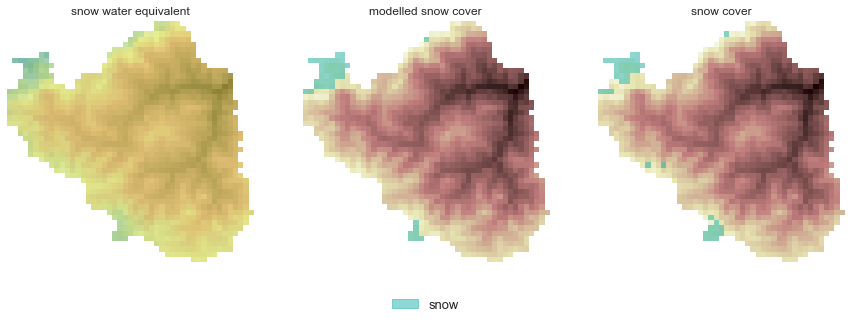

In [36]:
time = SCobs.times[30]
print(time)
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

for i, (ax, Var) in enumerate(zip(axes, [SWEsim8, SCsim8, SCobs])):
    ax.imshow(DEM.data, extent=DEM.extent, cmap='pink')
    if i == 0:
        ax.imshow(np.nanmean(Var.data, axis=0), extent=Var.extent(), cmap='summer_r', alpha=.5)
    else:
        ax.imshow(np.nanmean(Var.data, axis=0), extent=Var.extent(), cmap=cmap_snow, norm=norm)
    ax.set_title(Var.variable)
    ax.axis('off')
fig.legend(handles=[snow_patch], loc=8, fontsize=13);

Exportando archivo C:\Users\jcr693\Documents\GitHub\Calibrar\notebooks\spotpy\../../output/SC_simulado_vs_observado_(calib).mp4


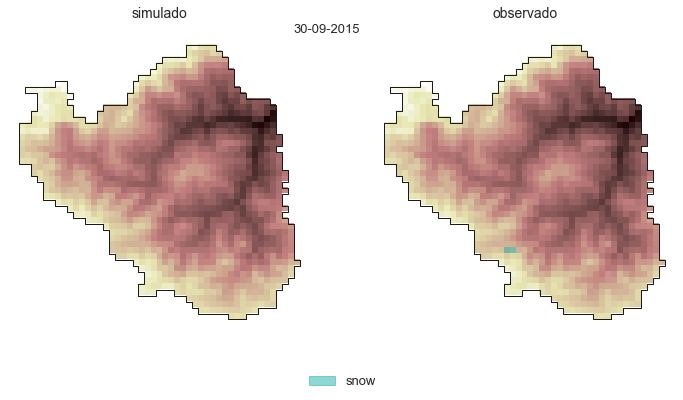

In [37]:
# vídeo simulado vs observado
mp4File = rutaOut + 'SC_simulado_vs_observado_(calib).mp4'
video2(SCsim8, SCobs, cuenca, cmap, norm, DEM, figsize=(12, 6), extent=extent,
       labels=['simulado', 'observado'], export=mp4File)